In [1]:
import warnings
warnings.filterwarnings("ignore")

import time
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTE
import xgboost as xgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV, PredefinedSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, make_scorer, classification_report, confusion_matrix

RANDOM_SEED = 1243
TEST_SIZE = 0.1

In [2]:
import sys
from importlib import reload

customPackages = ["visualizations", "modelling"]
for pkg in customPackages:
    reload(sys.modules[pkg]) if pkg in sys.modules else __import__(pkg)

vis = sys.modules["visualizations"].Visualizations()
mod = sys.modules["modelling"].Modelling(vis=vis)

In [3]:
def printTimeLapsed(startTime, endTime):
    s = (endTime - startTime)
    m, s = divmod(s, 60)
    h, m = divmod(m, 60)
    print("Time Lapsed = %02dh %02dm %02ds" % (int(h), int(m), int(s)))

In [4]:
preprocData = pickle.load(file=open("data/preprocData.pkl", "rb"))
X = preprocData["X"]
y = preprocData["y"]
X_test = preprocData["X_test"]
y_test = preprocData["y_test"]

print("Shape of the train/test data: %s / %s" % (str(X.shape), str(X_test.shape)))

Shape of the train/test data: (5830, 77) / (682, 77)


In [5]:
X_train, X_val, y_train, y_val = mod.splitData(X=X, y=y, testSize=TEST_SIZE, randomSeed=RANDOM_SEED, resetIndex=False)

smoteModel = SMOTE(random_state=RANDOM_SEED)
X_train_sm, y_train_sm = smoteModel.fit_resample(X, y)

startTime = time.time()
testFold = [-1] * X_train_sm.shape[0]
for valIdx, valRow in X_val.iterrows():
    for smIdx, smRow in X_train_sm.iterrows():
         if (np.array_equal(valRow, smRow)):
             testFold[smIdx] = 0
             break

predefSplit = PredefinedSplit(test_fold=testFold)
endTime = time.time()
printTimeLapsed(startTime=startTime, endTime=endTime)

Time Lapsed = 00h 01m 51s


In [6]:
rfModel = RandomForestClassifier(n_estimators=200, random_state=RANDOM_SEED)
rfModel.fit(X_train_sm, y_train_sm)
rfPreds = rfModel.predict(X_test)

F1-score = 49.06% 

              precision    recall  f1-score   support

      Stable       0.99      0.97      0.98       660
    Bankrupt       0.42      0.59      0.49        22

    accuracy                           0.96       682
   macro avg       0.70      0.78      0.73       682
weighted avg       0.97      0.96      0.96       682



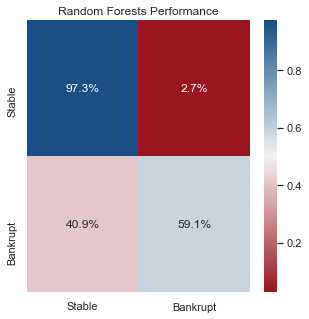

In [7]:
mod.getModelPerformance(trueVals=y_test, preds=rfPreds, figSize=(5,5), plotTitle="Random Forests Performance", targetNames=["Stable","Bankrupt"])

In [8]:
xgbParams = {
    "n_estimators": 500,
    "eta" : 0.1,
    "reg_lambda" : 1,
    "reg_alpha" : 1, 
    "max_depth" : 6, 
    "gamma" : 0.01, 
    "min_child_weight": 3,
    "subsample": 0.67,
    "colsample_bytree": 0.67,
    "objective":"binary:logistic",
    "eval_metric": "logloss"
    }

xgbModel = xgb.XGBClassifier(**xgbParams, use_label_encoder=False, random_state=RANDOM_SEED)
xgbModel.fit(X_train_sm, y_train_sm)
xgbPreds = xgbModel.predict(X_test)

F1-score = 53.06% 

              precision    recall  f1-score   support

      Stable       0.99      0.98      0.98       660
    Bankrupt       0.48      0.59      0.53        22

    accuracy                           0.97       682
   macro avg       0.73      0.78      0.76       682
weighted avg       0.97      0.97      0.97       682



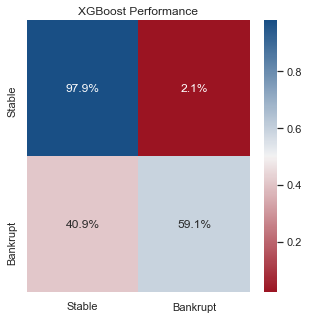

In [9]:
mod.getModelPerformance(trueVals=y_test, preds=xgbPreds, figSize=(5,5), plotTitle="XGBoost Performance", targetNames=["Stable","Bankrupt"])

In [10]:
xgbParams = {
    "n_estimators": [500],
    "reg_lambda": [1, 3, 10], 
    "reg_alpha": [1, 3, 10], 
    "eta": [0.1, 0.2], 
    "gamma": [0.01], 
    "max_depth": [3, 6],
    "min_child_weight": [3],
    "subsample": [0.67],
    "colsample_bytree": [0.67],
    "objective": ["binary:logistic"],
    "eval_metric": ["logloss"]
    }
xgbcvModel = xgb.XGBClassifier(use_label_encoder=False, random_state=RANDOM_SEED)

In [11]:
MAX_PARAM_COMBOS = 100
totalParamCombos = np.product([len(xgbParams[key]) for key in xgbParams.keys()])
nParamCombos = min(totalParamCombos, MAX_PARAM_COMBOS)

f1Scorer = make_scorer(f1_score, average="micro")
randomSearch = RandomizedSearchCV(
    xgbcvModel, param_distributions=xgbParams, n_iter=nParamCombos, scoring=f1Scorer,
    n_jobs=4, cv=predefSplit, verbose=3, random_state=RANDOM_SEED
    )

In [12]:
startTime = time.time()
randomSearch.fit(X_train_sm, y_train_sm)
xgbcvPreds = randomSearch.predict(X_test)
endTime = time.time()
printTimeLapsed(startTime=startTime, endTime=endTime)

Fitting 1 folds for each of 36 candidates, totalling 36 fits
Time Lapsed = 00h 02m 04s


In [13]:
print(randomSearch.best_params_)
print("Best score from randomized grid search = %.4f" % randomSearch.best_score_)

{'subsample': 0.67, 'reg_lambda': 3, 'reg_alpha': 1, 'objective': 'binary:logistic', 'n_estimators': 500, 'min_child_weight': 3, 'max_depth': 3, 'gamma': 0.01, 'eval_metric': 'logloss', 'eta': 0.2, 'colsample_bytree': 0.67}
Best score from randomized grid search = 0.9880


In [14]:
cvResults = pd.DataFrame(randomSearch.cv_results_).sort_values("rank_test_score")

timeColumns = list(filter(lambda x: x.endswith("time"), cvResults.columns))
singleParamColumns = [("param_" + key) for key in xgbParams.keys() if len(xgbParams[key]) == 1]
cvResults.drop(columns=timeColumns + singleParamColumns + ["params", "std_test_score"], inplace=True)

cvResults.head(10)

,param_reg_lambda,param_reg_alpha,param_max_depth,param_eta,split0_test_score,mean_test_score,rank_test_score
19,3,1,3,0.2,0.987993,0.987993,1
23,10,3,3,0.2,0.986278,0.986278,2
18,1,1,3,0.2,0.986278,0.986278,2
29,10,1,6,0.2,0.984563,0.984563,4
0,1,1,3,0.1,0.982847,0.982847,5
28,3,1,6,0.2,0.982847,0.982847,5
20,10,1,3,0.2,0.981132,0.981132,7
14,10,3,6,0.1,0.981132,0.981132,7
12,1,3,6,0.1,0.981132,0.981132,7
11,10,1,6,0.1,0.981132,0.981132,7


F1-score = 56.00% 

              precision    recall  f1-score   support

      Stable       0.99      0.98      0.98       660
    Bankrupt       0.50      0.64      0.56        22

    accuracy                           0.97       682
   macro avg       0.74      0.81      0.77       682
weighted avg       0.97      0.97      0.97       682



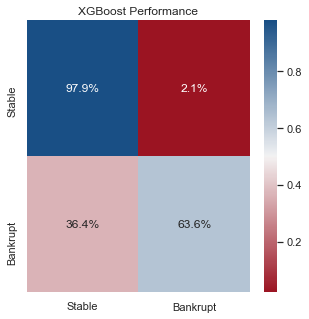

In [15]:
mod.getModelPerformance(trueVals=y_test, preds=xgbcvPreds, figSize=(5,5), plotTitle="XGBoost Performance", targetNames=["Stable","Bankrupt"])